# Importing a GDSII/OASIS Layout

Importing an existing GDSII or OASIS layout file is easy with PhotonForge.
Each cell in the layout is loaded as a [component](../_autosummary/photonforge.Component.rst) and the hierarchical structure in the file is preserved as PhotonForge [references](../_autosummary/photonforge.Reference.rst).

One important aspect to notice is that GDSII and OASIS files do not include a standard way to specify the PDK they use.
That means that we are responsible for loading the appropriate [technology](Technology.ipynb) for the file we want to import.

In this example, we'll load the GDSII file created in the [Mach-Zehnder interferometer example](../examples/Mach-Zehnder_Interferometer.ipynb).
That file was created for use with the [basic technology](../_autosummary/photonforge.basic_technology.rst) included in PhotonForge, but with a strip [waveguide profile](Ports.ipynb) with 450 nm core, so we first set that as our default technology.

In [1]:
import photonforge as pf

pf.config.default_technology = pf.basic_technology(strip_width=0.45)

With the technology set, loading the layout is done with the [load_layout](../_autosummary/photonforge.load_layout.rst) function, which returns a dictionary of components by name.

In [2]:
# Load the gds file
gds_file = "../examples/MZI.gds"
components = pf.load_layout(gds_file)
print("Components:", list(components.keys()))

Components: ['DELAY_STRAIGHT_10', 'BEND', 'DELAY_ARM_0', 'MZI', 'COUPLER', 'DELAY_ARM_10']


In [3]:
components["COUPLER"]

If we don't know which of the components are at the top-level in the cell hierarchy in the layout, the [find_top_level](../_autosummary/photonforge.find_top_level.rst) function can provide that information.

In [4]:
top_level = pf.find_top_level(*components.values())
print("Top level components:", [component.name for component in top_level])

Top level components: ['MZI']


We can visualize the dependency tree of any component using the [tree_view](../_autosummary/photonforge.Component.rst#photonforge.Component.tree_view) function (static or interactively):

In [5]:
mzi = components["MZI"]
mzi.tree_view()

MZI
├─ COUPLER
├─ DELAY_ARM_0
│  └─ BEND
└─ DELAY_ARM_10
   ├─ DELAY_STRAIGHT_10
   └─ BEND

In [6]:
mzi.tree_view(interactive=True)

MZI
├─ COUPLER
├─ DELAY_ARM_0
│  └─ BEND
└─ DELAY_ARM_10
   ├─ DELAY_STRAIGHT_10
   └─ BEND

Because we generated the default technology with the appropriate strip waveguide profile for this layout, [adding ports](Ports.ipynb) is easy with [port auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports):

In [7]:
ports = mzi.detect_ports(["Strip"])
print("Detected ports:\n" + "\n".join([f" - {p}" for p in ports]))

Detected ports:
 - Port at (-4.25, -6.55) at 90 deg of type Strip waveguide
 - Port at (-4.25, 0) at 270 deg of type Strip waveguide
 - Port at (18.75, -6.55) at 90 deg of type Strip waveguide
 - Port at (18.75, 0) at 270 deg of type Strip waveguide


In [8]:
mzi.add_port(ports, "P")
mzi

We can continue adding ports and models to all sub-components loaded from the layout to replicate the circuit simulation used in the [original example](../examples/Mach-Zehnder_Interferometer.ipynb).

However, if the component tree is large, this process can become very tedious.
Instead, we can add the ports only to the leaf components in the tree (components without sub-components) and process all others automatically.

We start by finding all leaf components:

In [9]:
leaves = [c.name for c in mzi.dependencies() if len(c.references) == 0]
leaves

['COUPLER', 'BEND', 'DELAY_STRAIGHT_10']

Each of those components we have to process individually, because they have unique characteristics:

In [10]:
coupler = components["COUPLER"]

coupler.add_port(coupler.detect_ports(["Strip"]), "P")
assert len(coupler.ports) == 4

coupler.add_model(
    pf.Tidy3DModel(
        port_symmetries=[
            ("P1", "P0", "P3", "P2"),
            ("P2", "P3", "P0", "P1"),
            ("P3", "P2", "P1", "P0"),
        ],
        verbose=False,
    ),
    "Tidy3DModel",
)
coupler

In [11]:
bend = components["BEND"]

bend.add_port(bend.detect_ports(["Strip"]), "P")
assert len(bend.ports) == 2

bend.add_model(pf.Tidy3DModel(port_symmetries=[("P1", "P0")]), "Tidy3DModel")
bend

In [12]:
straight = components["DELAY_STRAIGHT_10"]

straight.add_port(straight.detect_ports(["Strip"]), "P")
assert len(straight.ports) == 2

straight.add_model(pf.WaveguideModel(verbose=False), "WaveguideModel")
straight

Now, for all intermediate components in the hierarchy and the top level MZI we simply want to add the ports derived from their sub-components and a [circuit models](Circuit_Model.ipynb) to combine their S matrices.
The method [add_reference_ports](../_autosummary/photonforge.Component.rst#photonforge.Component.add_reference_ports) was created exactly for this purpose:

In [13]:
mzi.add_reference_ports(add_model=pf.CircuitModel(), include_dependencies=True)

for component in [mzi] + mzi.dependencies():
    print(
        f"{component.name}: ports = {list(component.ports)}; active model = {component.active_model}"
    )

MZI: ports = ['P3', 'P2', 'P1', 'P0']; active model = CircuitModel
COUPLER: ports = ['P3', 'P2', 'P1', 'P0']; active model = Tidy3DModel
DELAY_ARM_0: ports = ['P1', 'P0']; active model = CircuitModel
BEND: ports = ['P1', 'P0']; active model = Tidy3DModel
DELAY_ARM_10: ports = ['P1', 'P0']; active model = CircuitModel
DELAY_STRAIGHT_10: ports = ['P1', 'P0']; active model = WaveguideModel


We may check the [netlists](../_autosummary/photonforge.Component.rst#photonforge.Component.get_netlist) of the components with [circuit models](../_autosummary/photonforge.CircuitModel.rst) to make sure we connected all sub-components correctly.
If any sub-component is disconnected or missing a model, we'll get an error or warning when computing the scattering matrix.

Loading cached simulation from .tidy3d/pf_cache/DP7/ms_info-A5FYNSQPYOICFG7TY2JXZTV6HTGBCIQTJ7ZWD6JE75WKY6CPKDAQ.json.
Loading cached simulation from .tidy3d/pf_cache/GR4/ms_info-PLFVDCS2W7HQJJ2X2QOSTIMHFHBRIFBZEKXTDYI63PURKGJ3ZUBQ.json.


Loading cached simulation from .tidy3d/pf_cache/DSH/fdtd_info-NPMHRNWLO4QMGJQWLPSTE5RRJCBRGA7CMZZXDJGX2R6YWVRIVFGQ.json.


Loading cached simulation from .tidy3d/pf_cache/TD3/ms_info-OWMRXB4C6LGQVMUOFXGMERS572YNJCK2OO3ZKZJ2HXLMMBEDXSJQ.json.


Loading cached simulation from .tidy3d/pf_cache/PRP/ms_info-XXSM2JV4OGLFXZFHNI4IHDBFFG6F647SBK3S3FPR4XVCJP2SZ3FQ.json.
Progress: 100% 


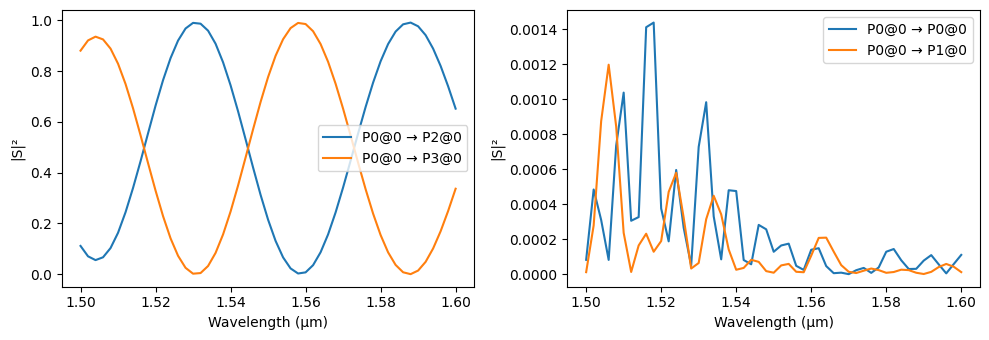

In [14]:
import numpy as np

s_matrix = mzi.s_matrix(pf.C_0 / np.linspace(1.5, 1.6, 51))

_ = pf.plot_s_matrix(s_matrix, input_ports=["P0"])